In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from random import seed, shuffle
import os

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set_theme(style="white")

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.cluster import KMeans, SpectralClustering

from scipy import stats
from scipy.spatial.distance import directed_hausdorff, euclidean, cosine, pdist

from src.downsample import downsamp_audio
import src.embedding_extractor as ee
import src.dimension_reducer as dr
import src.distance_metrics as dm

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

one_samp_toy_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/one_samp_toy_downsamp' #toy dataset with one participant recording @16kHz
#two_samp_toy_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/two_samp_toy_downsamp'#toy dataset with two participant recordings @16kHz
two_samp_toy_dir ='/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/020422_postpartum_moms_two_samp_toy'
down_sampled_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/downsamp'#all the data, downsampled to 16kHz
embedding_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/embeddings' #location of embeddings save new embeddings load pre-generated ones from here
emb_models = ['emb_ami', 'emb','emb_voxceleb'] #names of pretrained embedding extractor models

##files starting with 020422 are from the recent recordings of actual moms sohye sent
## files starting with 020322 were all the test recordings from last year

#the directory has other csvs and i only want today's
file = [file for file in os.listdir(embedding_dir) if file.startswith("020422")] 

#create a dictionary where each item is the pd df of the embeddings extracted from that model
all_embs = {emb_models[index]: ee.load_embs(os.path.join(embedding_dir,file[index])) for index in np.arange(len(file))}



emb = all_embs[emb_models[0]]
emb_down = ee.resample_data(emb,1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
#Using tsne with perplexity=30 (default) since N/100<30, and learning rate of n/12. Random seed is 42 so the result is the same each time
emb_tsne = dr.run_tsne(emb_down, perplexity=80, init='pca', learning_rate=emb_down.shape[0]//12)

In [18]:
#run umap with default parameters
emb_umap = dr.run_umap(emb_down)

In [5]:
lda = LinearDiscriminantAnalysis()
X = emb_down.drop(columns='part_id')
labels = emb_down.part_id

emb_lda = pd.DataFrame(lda.fit_transform(X, labels))

In [19]:
high_dim = emb_down.drop(columns='part_id').to_numpy()
classes= emb_down.part_id.to_numpy()

low_dim = emb_tsne.drop(columns='part_id').to_numpy()
dist_tsne = dm.embedding_quality(high_dim, low_dim, classes,subsetsize=emb_down.shape[0])

low_dim = emb_umap.drop(columns='part_id').to_numpy()
dist_umap = dm.embedding_quality(high_dim, low_dim, classes,subsetsize=emb_down.shape[0])

low_dim = emb_lda.iloc[:,:2].to_numpy()
dist_lda = dm.embedding_quality(high_dim, low_dim, classes, subsetsize=emb_down.shape[0])

In [20]:
#'knn', 'knc', 'cpd' are micro, meso, and marco structure per Kobak&Berens2019
dist = pd.DataFrame(np.vstack((dist_tsne, dist_umap,dist_lda)), columns = ['micro', 'meso', 'macro'], index = ['tsne', 'umap', 'lda'])
dist = dist.round(decimals=3)
dist

,micro,meso,macro
tsne,0.469,0.776,0.723
umap,0.377,0.582,0.328
lda,0.055,0.741,0.374


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[Text(0.5, 1.0, '     micro   meso  macro\nlda  0.055  0.741  0.374')]

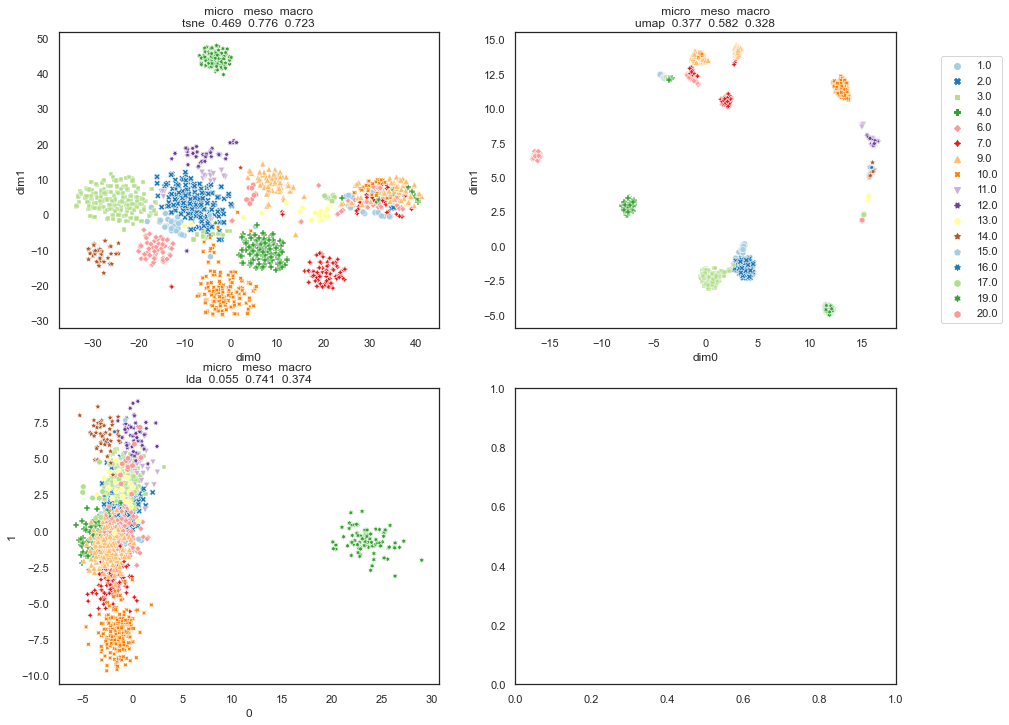

In [21]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(15,12))

clust_plt_tsne = sns.scatterplot(x=emb_tsne.dim0, y=emb_tsne.dim1, ax=ax1, palette="Paired", hue=emb_tsne.part_id, style=emb_tsne.part_id, legend=False)
#ax1.legend(loc="lower center",bbox_to_anchor=(1.3,1), ncol=2)
clust_plt_tsne.set(title = str(dist[dist.index=='tsne']))

clust_plt_umap = sns.scatterplot(x=emb_umap.dim0, y=emb_umap.dim1, ax=ax2, palette="Paired", hue=emb_umap.part_id, style=emb_tsne.part_id)
ax2.legend(loc="lower center",bbox_to_anchor=(1.2, 0), ncol=1)
clust_plt_umap.set(title = str(dist[dist.index=='umap']))

clust_plt_lda = sns.scatterplot(x=emb_lda.iloc[:,0], y= emb_lda.iloc[:,1], ax=ax3, palette="Paired", hue = labels, style=emb_tsne.part_id, legend=False)
ax3.legend(loc="lower center",bbox_to_anchor=(1.3, 0.4), ncol=2)
clust_plt_lda.set(title = str(dist[dist.index=='lda']))

<AxesSubplot:>

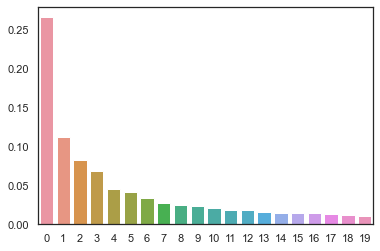

In [22]:
pca = PCA(n_components=512)
exp_var = pca.fit(emb_down.drop(columns='part_id')).explained_variance_ratio_
sns.barplot(x=np.arange(20), y=exp_var[0:20])

<AxesSubplot:xlabel='dim0', ylabel='dim1'>

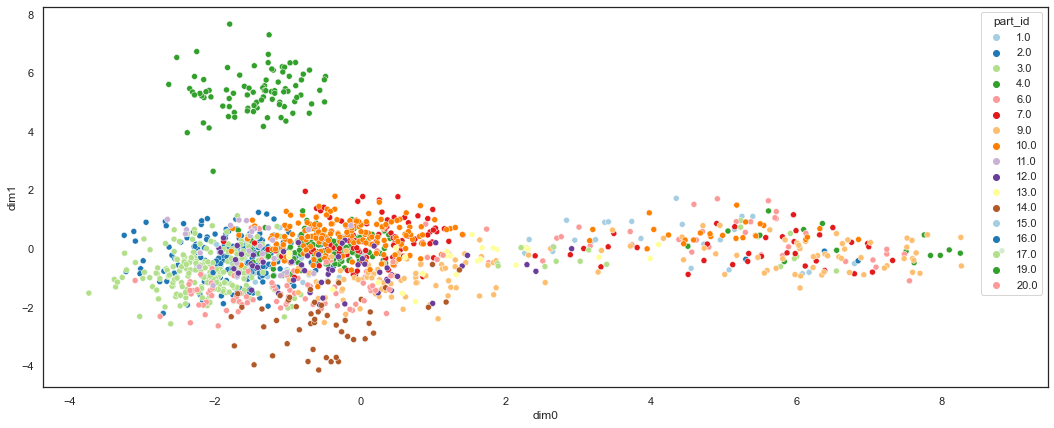

In [23]:
fig, ax = plt.subplots(figsize=(18,7))
emb_pca = pd.DataFrame(pca.fit_transform(emb_down.drop(columns='part_id')))
emb_pca = emb_pca.iloc[:,:2]
emb_pca.columns = ['dim0', 'dim1']

sns.scatterplot(x=emb_pca.dim0, y=emb_pca.dim1, palette="Paired", hue=emb_tsne.part_id)